In [5]:
from pyedflib import EdfReader
import pywt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import re
from timeit import default_timer as timer 

In [6]:
# ---------------- FILE READING ---------------- #

def read_record_files(dataset_path): 
    """
    Open and store the names of all files and of the ones with seizures

        param dataset_path: the path to the dataset, string

        return files: list of names of all the files, on the form 'chb01/chb01_01'
        return files_seizures: list of names of all the files with seizures, on the form 'chb01/chb01_01'
    """
    records = open(dataset_path + '/' + 'RECORDS_TXT.txt', 'r')
    records_seizures = open(dataset_path + '/' + 'RECORDS-WITH-SEIZURES_TXT.txt', 'r')
    files = records.readlines()
    files_seizures = records_seizures.readlines()
    records.close()
    records_seizures.close()
    return files, files_seizures

In [7]:
# ---------------- FEATURE CALCULATION ---------------- #

def teager_energy(data):
    sum_values = sum(abs(data[x]**2) if x == 0
                     else abs(data[x]**2 - data[x - 1] * data[x + 1])
                     for x in range(0, len(data) - 1))
    if sum_values == 0:
        return 0  # Avoids log(0) with flat sub-bands/signals
    return np.log10((1 / float(len(data))) * sum_values)
    
    # return 1 # debugging


def instantaneous_energy(data):
    if sum(i ** 2 for i in data) == 0:
        return 0  # Avoids log(0) with flat sub-bands/signals
    return np.log10((1 / float(len(data))) * sum(i ** 2 for i in data))
    
    # return 1 # debugging

In [8]:
# ---------------- FEATURE EXTRACTION ---------------- #

def get_seizure_start_end(fname_path): 
    """
    Finds the start time and end time for the seizure from the summary file for each patient. 
    There can be more than one seizure per file

        param: fname_path: the path to the file with the seizure, string

        return start_time: when the seizure starts, list of strings  
        return end_time: when the seizure ends, list of strings
    """
    start_time = []
    end_time = []
    summary_file = open(fname_path[:-7] + '-summary.txt','r')
    for line in summary_file: 
        seizure_start = re.search("Seizure\s\d\sStart", line)
        if seizure_start is not None: 
            start_time += line.split()[4:][:-1]
        seizure_end = re.search("Seizure\s\d\sEnd", line)
        if seizure_end is not None: 
            end_time += line.split()[4:][:-1]
    summary_file.close()
    return start_time, end_time


def calculate_features(dwt, feature_vector):
    """
    Calculating features from the decomposition levels

        param dwt: the dwt levels, list
        param fature_vector: the vector to add more features to

        return feature_vector: updated feature_vector with onw more row of features
    """
    feature = []
    for dwt_value in dwt: 
        feature_vector += [teager_energy(dwt_value), instantaneous_energy(dwt_value)]
    feature_vector += feature
    #print(len('features_no_seizure', features_no_seizure)) # for debugging
    return feature_vector


def read_files(dataset_path, files, files_seizures, Fs): 
    """
    Reads the signal for each patient, for each trail and each channel. 
    TODO: the code now reads only the files for patient 12 to reduce runtime 
    Each signal is decomposed into 4 levels using DWT. 
    From the four levels two features are found: instantaneous energy and teager energy
    TODO: add more features when runtime is better
    These are added to two feature vectors for all the patients: one with and one without seizure 

        param dataset_path: the path to the dataset, string
        param files: names of all the files, on the form 'chb01/chb01_01', list
        param files_seizures: names of all the files with seizures, on the form 'chb01/chb01_01', list
        param Fs: sampling frequency

        return features_seizures: features for signals with seizures, list
        return features_no_seizures: features for signals without signals, list
    """

    # Variables
    features_no_seizure = []
    features_seizure = []

    # For all files in the wholde dataset
    for file in files:
        if (file.startswith('chb12/')): # TODO: remove this to run the code for all patients. Keep it to make the code run faster and debugging
            print('File', file) # debugging
            fname_path = dataset_path + '/' + file.strip()
            f = EdfReader(fname_path)
            channel_names = f.getSignalLabels() # TODO: can I come up with a better solution?

            for channel in range(len(channel_names)): 
                # print('Channel', channel) # debugging
                signal = f.readSignal(channel)

                if file in files_seizures: # If the file has a seizure we need to separate the seizure signal from the non-seizure signal
                    # Get seizure interval from files: 
                    start_time, end_time = get_seizure_start_end(fname_path)

                    # For each seizure we collect the signal to do dwt and find features
                    for i in range(len(start_time)): 
                        seizure_start = int(start_time[i])
                        seizure_end = int(end_time[i])
                        seizure_signal = signal[int(seizure_start*Fs):int(seizure_end*Fs)]
                        if len(seizure_signal) > 0 : # get rid of signals with lenght 0, TODO: why is chb12/chb12_11 []?
                            dwt = pywt.wavedec(seizure_signal, 'bior2.2', level=4)
                            features_seizure = calculate_features(dwt, features_seizure)

                else: # no seizure in file
                    dwt = pywt.wavedec(signal, 'bior2.2', level=4)
                    features_no_seizure = calculate_features(dwt, features_no_seizure)
                    # print('Len fature_vector', len(features_no_seizure)) # debugging

    return features_no_seizure, features_seizure


dataset_path = "C:/Users/marieov/OneDrive - NTNU/NTNU/9. semester/Project thesis/github/Project-thesis/CHB_MIT" # TODO: in config
Fs = 256 # TODO: downsample to 128

files, files_seizures = read_record_files(dataset_path)
start = timer()
features_no_seizure, features_seizure = read_files(dataset_path, files, files_seizures, Fs)
print("Time:", timer()-start)


File chb12/chb12_06.edf

Channel 0
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 1
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 2
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 1

1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 22
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 23
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450

1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 15
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 16
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 17
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3

1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 9
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 10
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 

1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 2
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 3
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676


1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 24
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 25
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447

1199 1170
1701 1676
2236 2213
Channel 17
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 18
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 19
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 26

1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 4
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 5
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1

146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 25
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 26
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 27
1726 1665
3447 3415
1439 1426
1614 

951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 16
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 17
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170


3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 8
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 9
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 10
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
112

333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 1
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 2
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 

750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 22
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 23
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 24
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2

2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 12
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 13
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 14
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856

Len fature_vector 1850
Channel 15
Len fature_vector 1860
Channel 16
Len fature_vector 1870
Channel 17
Len fature_vector 1880
Channel 18
Len fature_vector 1890
Channel 19
Len fature_vector 1900
Channel 20
Len fature_vector 1910
Channel 21
Len fature_vector 1920
Channel 22
Len fature_vector 1930
Channel 23
Len fature_vector 1940
Channel 24
Len fature_vector 1950
Channel 25
Len fature_vector 1960
Channel 26
Len fature_vector 1970
Channel 27
Len fature_vector 1980
Channel 28
Len fature_vector 1990
File chb12/chb12_36.edf

Channel 0
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 1
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503


3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 21
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 22
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1

2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 10
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 11
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 12
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630

Len fature_vector 2510
Channel 23
Len fature_vector 2520
Channel 24
Len fature_vector 2530
Channel 25
Len fature_vector 2540
Channel 26
Len fature_vector 2550
Channel 27
Len fature_vector 2560
Channel 28
Len fature_vector 2570
File chb12/chb12_40.edf

Channel 0
Len fature_vector 2580
Channel 1
Len fature_vector 2590
Channel 2
Len fature_vector 2600
Channel 3
Len fature_vector 2610
Channel 4
Len fature_vector 2620
Channel 5
Len fature_vector 2630
Channel 6
Len fature_vector 2640
Channel 7
Len fature_vector 2650
Channel 8
Len fature_vector 2660
Channel 9
Len fature_vector 2670
Channel 10
Len fature_vector 2680
Channel 11
Len fature_vector 2690
Channel 12
Len fature_vector 2700
Channel 13
Len fature_vector 2710
Channel 14
Len fature_vector 2720
Channel 15
Len fature_vector 2730
Channel 16
Len fature_vector 2740
Channel 17
Len fature_vector 2750
Channel 18
Len fature_vector 2760
Channel 19
Len fature_vector 2770
Channel 20
Len fature_vector 2780
Channel 21
Len fature_vector 2790
Channel 22

1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 16
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 17
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3114 3082
3535 3503
625 593
856 811
1122 1085
333 253
522 425
670 630
951 916
1124 1097
1753 1728
1963 1921
2440 2388
2669 2621
215 181
146 107
592 554
1199 1163
1447 1401
1921 1884
3584 3557
2206 2185
2450 2427
680 653
1573 1548
2821 2798
3009 2966
3201 3146
3410 3364
750 699
973 945
1199 1170
1701 1676
2236 2213
Channel 18
1726 1665
3447 3415
1439 1426
1614 1591
1977 1957
2824 2798
3

In [9]:
# ------------------ MACHINE LEARNING PREPROCESSING ------------------ #

def create_labels(features_no_seizure, features_seizure):
    """
    Creating labels for the features found
    0 is no seizure
    1 is seizure

        param features_seizures: features for signals with seizures, list
        param features_no_seizures: features for signals without signals, list

        return labels: labels 0 or 1, list
    """
    labels_no_seizure = np.zeros(len(features_no_seizure))
    labels_seizure = np.ones(len(features_seizure))
    labels = np.append(labels_no_seizure, labels_seizure)
    return labels

labels = create_labels(features_no_seizure, features_seizure)
features = np.append(features_no_seizure, features_seizure)


In [10]:
print(len(features_no_seizure))
print(len(features_seizure))
# TODO: The dataset looks very unbalanced?

3150
145600


Most important features [0]
Accuracy test:  0.965 Accuracy train:  0.996 Error precentage 3.54 f1 score:  0.534 Precision:  0.539 Recall:  0.53


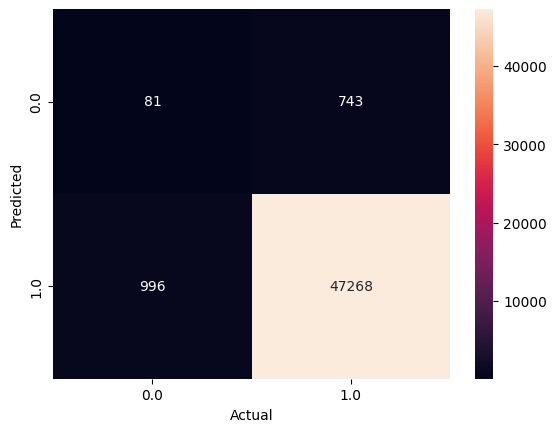

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# ------------------ RANDOM FOREST ------------------ #
# TODO: document

def confusion_matrix_heatmap(target, predicted, perc=False):
    plt.figure()
    data = {'y_Actual': target, 'y_Predicted': predicted}
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    c_matrix_l = pd.crosstab(df['y_Predicted'], df['y_Actual'],
        rownames=['Predicted'], colnames=['Actual'])
    if perc:
        sns.heatmap(c_matrix_l/np.sum(c_matrix_l),
            annot=True, fmt='.2%', cmap='Blues')
    else:
        sns.heatmap(c_matrix_l, annot=True, fmt='d')


def get_metrics(y_test, y_train, y_rf_predict_test, y_rf_predict_train, cmatrix_plot=False, _print=False, _title="", _average="macro"):#micro, macro
    if cmatrix_plot:
        confusion_matrix_heatmap(y_test, y_rf_predict_test) # _title="Test set")
    _acc_test = round(accuracy_score(y_test, y_rf_predict_test), 3)
    _acc_train = round(accuracy_score(y_train, y_rf_predict_train), 3)
    _fscore = round(f1_score(y_test, y_rf_predict_test, average=_average), 3)
    _precision = round(precision_score(y_test, y_rf_predict_test, average=_average), 3)
    _recall = round(recall_score(y_test, y_rf_predict_test, average=_average), 3)
    _errors = abs(y_rf_predict_test - y_test)
    _error_precentage = round(np.sum(_errors)/len(_errors)*100, 2)
    
    if _print:
        print( "Accuracy test: ",_acc_test, "Accuracy train: ", _acc_train, "Error precentage", _error_precentage, "f1 score: ", _fscore, "Precision: ", _precision, "Recall: ", _recall)
    # return _acc_test,_acc_train,_fscore,_precision,_recall
    
    
def find_important_features(rf): 
    # TODO: check out this https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    important_features_dict = {}
    for xx, i in enumerate(rf.feature_importances_):
        important_features_dict[xx] = i
    important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse = True)
    print('Most important features', important_features_list)

    
def random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state=0)
    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)
    rf.fit(X_train, y_train)
    
    y_rf_predict_test = rf.predict(X_test)
    y_rf_predict_train = rf.predict(X_train)

    find_important_features(rf)
    get_metrics(y_test, y_train,y_rf_predict_test, y_rf_predict_train,cmatrix_plot=True,_print=True)
    
    
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

# running the random forest classifier
random_forest(X_train, X_test, y_train, y_test)